In [12]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%run ../aux_funcs.py
%run ../RSRG.py
%run ../RSRG_class.py

In [5]:
with open("Ising_2D_h_dist_1676191635.pkl", "rb") as fp:   # Unpickling
    h_dist_list = pickle.load(fp)
    
with open("Ising_2D_input_1676191635.pkl", "rb") as fp:   
    input_dict = pickle.load(fp)

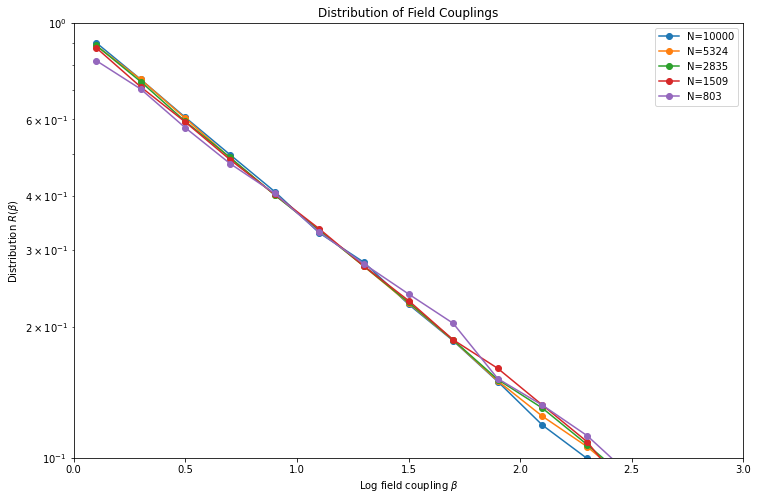

In [28]:
measure_list = input_dict['measure_list']
n_runs = input_dict['n_runs']
n_bins_h = 60

plt.figure(figsize=(12, 8))

for i,step in enumerate(measure_list):
    if i%4==0: 
        n,bins = np.histogram(h_dist_list[i], density=True, bins = n_bins_h, range=(0,12))
        width = bins[1]-bins[0]
        plt.plot((bins[1:]-width/2), n, label="N="+str(step), marker='o')

plt.yscale('log')
plt.xlim(0, 3)
plt.ylim(1e-1, 1)

plt.xlabel(r"Log field coupling $\beta$")
plt.ylabel(r"Distribution $R(\beta)$")
plt.title("Distribution of Field Couplings")
plt.yscale('log')
plt.legend()

In [8]:
input_dict

{'L': 100,
 'steps': 9500,
 'measure_list': array([10000,  8542,  7296,  6233,  5324,  4548,  3885,  3318,  2835,
         2421,  2068,  1767,  1509,  1289,  1101,   940,   803,   686,
          586,   500]),
 '(a,b)': (0.1, 0.1),
 'n_runs': 480}